# Exploring related sequences and structures

Ensuring an effective and global response to potential pandemic emergencies requires the development of broad-spectrum antiviral therapeutics, capable of targeting multiple protein variants. Advancing these therapeutics requires designing ligands that can effectively interact with multiple protein targets.    
In response to this need, we have developed the `asap-genetics` tool. This tool simplifies the design of broad-spectrum antivirals by enabling users to: 1) search for all the related sequences of a protein target of interest, and 2) generate and align the structures of these related targets for further visualization and testing.


This tutorial will guide you through the process of querying a protein sequence on BLAST to find related proteins and align their sequences and structures.
The notebook is divided as follows:
1. Runing a BLAST search on a query protein sequence.
2. Performing a multi-sequence alignment between the reference and a sub-set of the matching sequences, based on a selection criteria.
3. Preparing a job on ColabFold to generate structures of the related proteins.
4. Generating a PyMol session with the structures of reference and related proteins.
5. How to do all the above steps in the command-line!

In [1]:
from pathlib import Path
import pandas as pd

from asapdiscovery.genetics.blast import PDBEntry, get_blast_seqs
from asapdiscovery.genetics.seq_alignment import Alignment, do_MSA

We will save our results from this run on a separate directory, because we expect a lot of output files! 

In [20]:
output_dir = "tutorial_results"
output_dir = Path(output_dir)
output_dir.mkdir(parents=True, exist_ok=True) # Avoids the warning when the directory has already been created

## BLAST search on a query protein sequence

We start with an input fasta file, containing the sequence of the protein of interest. For example, the fasta `sars-cov2-mpro.fasta` contains the sequence of one of the chains in SARS-CoV-2 Mpro.

In [21]:
input_fasta = "sars-cov2-mpro.fasta"
print(open(input_fasta, "r").read())

SARS-CoV-2 Mpro Chain A, B
SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ



Now, time to run the BLAST search!    
Our code call the `Bio.Blast.NCBIWWW` module from BioPython, which queries from the NCBI BLAST server. There's a few parameters from BLAST we are interested in, because they control the number of matches we get from our search:

- `nalign`: The number of database sequences BLAST will show alignments for.
- `nhits`: The number of hit sequences to return.
- `e_val`: Expect value (E) for saving hits.

In general, we want to maximize the number of sequence matches! In the next step we will learn how to apply other filters to our BLAST output, but we wold like to have as big of a pool to select from as possible.  

We will use the defaults `nalign=500` and `nhits=100` for this tutorial to limit the size of our output, but we recommend using >1000 for the alignments and a similar number for the hits for production runs (by definition, keep `nalign`>`nhits`). The BLAST default for `e_val` is 10, which is a good value for exploratory searches. You can improve the quality of your search by decreasing the expect value, at the risk of limiting the size of your output. 

We will also save the output of the BLAST run to a CSV file for book-keeping.

In [22]:
save_csv = "blast_log.csv"

And now we are ready to run our search!    
_(This should take a few minutes because we have to submit and retrieve our search to/from the BLAST servers)_

In [50]:
matches_df = get_blast_seqs(
    input_fasta,
    output_dir,
    input_type="fasta",
    save_csv=save_csv,
    nalign=500,
    nhits=100,
    e_val_thresh=10,
    verbose=False,
    xml_file="results.xml"
)
matches_df.head()

BLAST search with 500 alignments, expect 10, 100 hitlist_size and 100 descriptions


,query,ID,description,sequence,host,organism,score
0,unnamed protein product,ref|YP_009725295.1|,ORF1a polyprotein [Severe acute respiratory sy...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,,,100.00
1,unnamed protein product,ref|YP_009724389.1|,ORF1ab polyprotein [Severe acute respiratory s...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,,,100.00
2,unnamed protein product,ref|YP_009725301.1|,3C-like proteinase [Severe acute respiratory s...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,,,100.00
3,unnamed protein product,ref|YP_009944365.1|,ORF1a polyprotein [SARS coronavirus Tor2],SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTA...,,,96.08
4,unnamed protein product,ref|NP_828849.7|,ORF1ab polyprotein [SARS coronavirus Tor2],SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTA...,,,96.08


Alternatively, we could already have a PDB file with our reference's crystal structure. We can initialize the BLAST search with the PDB file and generate a `fasta` file from our PDB structure, by changing the `input_type` to `"pdb"`.  
  
_**WARNING:** This run will take longer than the previous one, because BLAST discourages multiple queries of the same sequence within a short time frame. You can skip this cell if you'd like, the rest of the notebook will run!_

In [ ]:
input_pdb = "8ya5.pdb" # SARS-Cov-2 MPRO rcsb input https://www.rcsb.org/structure/8YA5 
'''
matches_df_pdb = get_blast_seqs(
    input_pdb,
    output_dir,
    input_type="pdb",
    save_csv=save_csv,
    nalign=500,
    nhits=100,
    e_val_thresh=10,
    verbose=False,
    xml_file="results_pdb.xml"
)
matches_df_pdb.head()
'''

## Aligning the sequences from our BLAST search
Now that we have a list of protein sequencies that are related to our protein of interest, we want to visualize the similarities between the sequences. We will do this by aligning and visualizing multiple sequences from the BLAST output.

### Filtering our sequences based on a keyword match
The number of sequences returned by BLAST may get quite large, making it hard to find similarities between the protein sequences. Additionally, we may not even be interested in all of these! Some entries often share the same sequence (for example, diferent chains of the same protein), and others may simply not be relevant to us. For example, we could be interested in viral proteins that infect humans or we could be interested in MERS-CoV variants specifically. 

Information about a given sequence record can be found in the description provided by BLAST. The easiest way to filter our sequence is then search for specific keyword in this description, such as "human" or "MERS".

In [28]:
matches_df['description']

0     ORF1a polyprotein [Severe acute respiratory sy...
1     ORF1ab polyprotein [Severe acute respiratory s...
2     3C-like proteinase [Severe acute respiratory s...
3             ORF1a polyprotein [SARS coronavirus Tor2]
4            ORF1ab polyprotein [SARS coronavirus Tor2]
                            ...                        
95      ORF1ab polyprotein [Lucheng Rn rat coronavirus]
96                      nsp5 [Canada goose coronavirus]
97    ORF 1ab polyprotein [Beluga whale coronavirus ...
98           polyprotein ORF1a [Camel alphacoronavirus]
99    replicase polyprotein 1a [Human coronavirus 229E]
Name: description, Length: 100, dtype: object

Once we decide the keyword for our filter, we proceed to align sequences based on our filter. For this we define an `Alignment` object, which will take care of both tasks, given a query sequence (_"sars-cov2-mpro"_) and the DataFrame we obtained from the BLAST search:

In [29]:
query = matches_df["query"][0]
alignment = Alignment(matches_df, query, output_dir)

Fromt his alignment object, we will filter and align the resulting sequences. The MAFFT multi-sequence aligment tool will take care of the latter. Both steps will be run by the `do_MSA()` function, which takes the `Alignment` object and the selection parameter. In this case we also set the parameter `n_chains=1`, because our PDB structure contains only one chain. This parameter is not relevant for the visualization of the sequences (all BLAST entries correspond to a single chain), but will be for the next structure-alignment step of this tutorial.  

In [30]:
sel_key = "human"
file_prefix = "sars_tutorial"
selection_fasta, plot = do_MSA(
            alignment, sel_key, file_prefix, plot_width=1500, n_chains=1
        )

A fasta file tutorial_results/sars_tutorial.fasta have been generated with the selected sequences
A fasta file tutorial_results/sars_tutorial_alignment.fasta have been generated with the multi-seq alignment
A csv file tutorial_results/sars_tutorial.csv have been generated with the selected sequences
Aligning 6 sequences of lenght 317
A html file tutorial_results/sars_tutorial_alignment.html have been generated with the aligned sequences


This step should be completed pretty fast! You should see the following files in your `output_dir`:
- A `fasta` file with the ID, description and sequence of the entries selected via the provided keyword.
- An `.html` file with a colored representation of the multi-sequence alignment. The width of the plot can be adjusted via `plot_width` option.
- A `fasta` file with the aligned sequences (with “-” representing gaps inserted)
- A CSV file with the ID and sequence of the entries selected via the keyword. We will use this output in the next step of this tutorial.

Now, let's visualize the sequence alignment:   
_**WARNING:** This line will open a browser window with the alignment generated_

In [33]:
from bokeh.io import show
show(plot, notebook_handle=True)

### Sequences can also be selected based on the virus host, using the Entrez database

Entrez is a molecular biology database system that provides integrated access to nucleotide and protein sequence data. Importantly, it provides information on the organism and host of a given viral protein sequence. We are now going to query the Entrez database to filter our sequences based on viral host information.   
We will retrieve Entrez host information when we process our BLAST search, that way we can include this data in our BLAST csv output. 

Any Entrez search requires providing an email, as a way of controlling how much a single user queries the database (but, don't worry! They won't send any spam emails). 

Notice that we forgot to include our email in our previous BLAST run. Do we have to run the BLAST search again?

If you look through your results folder, you will notice a new file `results.xml` was saved. This is a backup of the BLAST results and can be used to retrieve the data from a previous run. This is really convenient as BLAST will take longer each time we submit the (same) sequence, so after a few queries the run will take 10+ mins. 

In [23]:
input_presaved = output_dir / "results.xml" 

matches_df = get_blast_seqs(
    input_presaved,
    output_dir,
    input_type="pre-calc",
    save_csv=save_csv,
    verbose=False,
    email="your.email@email.com" # Uncomment with your own email!!
)
matches_df.head()

,query,ID,description,sequence,host,organism,score
0,unnamed protein product,ref|YP_009725295.1|,ORF1a polyprotein [Severe acute respiratory sy...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,Homo sapiens,Severe acute respiratory syndrome coronavirus 2,100.00
1,unnamed protein product,ref|YP_009724389.1|,ORF1ab polyprotein [Severe acute respiratory s...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,Homo sapiens,Severe acute respiratory syndrome coronavirus 2,100.00
2,unnamed protein product,ref|YP_009725301.1|,3C-like proteinase [Severe acute respiratory s...,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,Homo sapiens,Severe acute respiratory syndrome coronavirus 2,100.00
3,unnamed protein product,ref|YP_009944365.1|,ORF1a polyprotein [SARS coronavirus Tor2],SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTA...,Homo sapiens; patient #2 with severe acute res...,SARS coronavirus Tor2,96.08
4,unnamed protein product,ref|NP_828849.7|,ORF1ab polyprotein [SARS coronavirus Tor2],SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTA...,Homo sapiens; patient #2 with severe acute res...,SARS coronavirus Tor2,96.08


To select based on Entrez information we will use a specific format:
    
`host: <host-species-name> OR organism: <organism-common-name>`
    
For example, `host: Homo sapiens OR organism: human` is a valid `sel_key` input that will look for sequences that infect humans by making sure either the corresponding *host* or *organism* entry contain the human keywords. **It is important to specify both** because sometimes Entrez entries do not contain host information but will almost always specify the organism.   
Let's run it!

In [31]:
query = matches_df["query"][0]
alignment = Alignment(matches_df, query, output_dir)

sel_key = "host: Homo sapiens OR organism: human"
file_prefix = "sars_tutorial_human_host"
selection_fasta, plot = do_MSA(
            alignment, sel_key, file_prefix, plot_width=1500, n_chains=1
        )

A fasta file tutorial_results/sars_tutorial_human_host.fasta have been generated with the selected sequences
A fasta file tutorial_results/sars_tutorial_human_host_alignment.fasta have been generated with the multi-seq alignment
A csv file tutorial_results/sars_tutorial_human_host.csv have been generated with the selected sequences
Aligning 8 sequences of lenght 320
A html file tutorial_results/sars_tutorial_human_host_alignment.html have been generated with the aligned sequences


And now we visualize the alignment again

In [32]:
from bokeh.io import show
show(plot, notebook_handle=True)

### OPTIONAL: Pulling PDB files from the RCSB database

Once you have generated the sequences, it may be useful to query the RCSB database for crystal structures of the proteins for further analysis.    
In the following lines we will: 1) Query the BLAST pdb database for entries matching our sequences with at least 99.9% identity, 2) Select the PDB entry with the highest crystal resolution, and 3) Download the best PDB structure for a protein sequence.


For the following block, you will need to install the ProDy package, with doesn't come pre-installed with asapdiscovery. Simply type the following line while on the conda environment:     

In [ ]:
%pip install -U ProDy

Once the installation is completed, we will request select the PDB files in just a couple of lines!    

We will define a `PDBEntry` object using a fasta file with the protein sequences we want to query. We refer to the fasta file with the related protein sequences we already saved previously, and proceed to retrieve the best crystal structure available with a minimum 99.9% match. We are actually only going to retrieve the reference structure by turning on the option `ref_only=True`, but you can turn it off to save the entries of all the matches.

In [63]:
pdb_entry = PDBEntry(seq=selection_fasta, type="fasta")
pdb_file_record = pdb_entry.retrieve_pdb(
    results_folder=output_dir, min_id_match=99.9, ref_only=True
)

record = pdb_file_record[0]
print(f"A PDB template for {record.label} was saved as {record.pdb_file}")

BLAST search with 500 alignments, expect 1e-20, 100 hitlist_size and 100 descriptions
Saving blast results in tutorial_results/pdb_blast.xml


@> Connecting wwPDB FTP server RCSB PDB (USA).


The best PDB entry is 6YB7, with match 100.0% and res 1.25A


@> Downloading PDB files via FTP failed, trying HTTP.
@> 6yb7 downloaded (tutorial_results/6yb7.pdb.gz)
@> PDB download via HTTP completed (1 downloaded, 0 failed).


A PDB template for ref|YP_009725295.1| was saved as tutorial_results/6yb7.pdb.gz


## Using ColabFold to generate PDB structures of our sequence matches

So far we have went from a reference protein sequence, to find all related viral proteins that infect humans, and visualizing how much the sequences relate to each other. To analyze how these differences translate into structural differences, we will feed the sequences into [ColabFold](https://github.com/sokrypton/ColabFold/tree/main?tab=readme-ov-file) to generate their corresponding structures with respect to a common template (in this case, the initial reference protein). Then, we will align and visualize the generated sequences with the reference and save a PyMOL session that will allow us to point to specific structural differences. 

You can install ColabFold in your local machine by following the instructions [here](https://github.com/YoshitakaMo/localcolabfold). The command-line `colabfold_batch` program takes as input a CSV file containing the ID and sequence of the structures we wish to fold, as well as the path to the directory all results will be stored.  
Optionally, we can also provide ColabFold with the PDB of a structure to use as template, as well as adjust the number of times the folded structure will be recycled, and the number of repetitions we want to generate (_e.g._, for improving the statistics of our model).     

The fold model can also be specified via `--model-type`. For monomers, _"alphafold2_ptm"_ is often appropiate, while multimers (`n_chains`>1 in the previous step) can be folded using the _"alphafold2_multimer_v3"_ model. We will run a job with 3 recycles, a single repetition and a monomer model.

The following is an example bash script for running ColabFold with the CSV file generated in the previous step, and the reference PDB saved in the directory `template_dir/`:

    csv_fn="<output_dir>/sars_tutorial_human_host.csv"
    template_dir="template_dir" # Ref pdb must be saved here
    out_dir="sars_cf_results"
    
    colabfold_batch $csv_fn $out_dir  \
        --templates --custom-template-path $template_dir \
        --num-recycle 3 --num-models 1 --model-type "alphafold2_ptm"

## Saving the aligned reference and related sequences on a PyMol session

The following section assumes you have completed your run on ColabFold and have generated structures for all the sequences saved in the `<file_prefix>.csv` file, created previously.

We will have all the files generated by ColabFold in a folder, for each molecule in the CSV file. If you chose to generate multiple repetitions of each protein fold (via the `-random-seed` option), you should have multiple PDB files per sequence, all following the same format:   _`"<mol_id>_unrelaxed_rank_001_<model_type>_model_1_seed_<seed_number>.pdb"`_, where a `<seed_number>` is assigned to each repetition and  `<model_type>` is the model used for the fold.

Let's define a function that will go through each `<mol_id>*.pdb` file in the directory, align and calculate the RMSD of each with respect to the reference and save a PyMOL session of the reference and folded proteins. If we have multiple seed repetitions saved, only those with the least RMSD with respect to the reference will be saved. 

In [92]:
from asapdiscovery.genetics.calculate_rmsd import (
    save_alignment_pymol,
    select_best_colabfold,
)
def gen_alignment_vis(sequence_df, cf_folder, ref_pdb, save_dir, pymol_save):
    
    aligned_pdbs = []
    seq_labels = []
    for index, row in sequence_df.iterrows():
        # iterate over each csv entry
        mol = row["id"]
        results = Path(cf_folder)
        final_pdb = save_dir / f"{mol}_aligned.pdb"

        # The output file format in ColabFold depends on the folding method used. 
        # Here the PDB file format is defined assuming the AlphaFold2_ptm model 

        # Select best seed repetition
        min_rmsd, min_file = select_best_colabfold(
            results_dir=results,
            seq_name=mol,
            pdb_ref=input_pdb, # reference pdb
            chain="A",
            final_pdb=final_pdb,
            fold_model="_unrelaxed_rank_001_alphafold2_ptm",
        )

        aligned_pdbs.append(min_file)
        seq_labels.append(mol)

    session_save = save_dir / pymol_save
    save_alignment_pymol(aligned_pdbs, seq_labels, ref_pdb, session_save)

    return 

If you followed the previous guide, all of the ColabFold results should be saved on the folder `sars_cf_results/`. Let's also use the PDB for SARS-CoV-2 introduced in the beginning of the notebook as reference. 

In [93]:
%reload_ext autoreload
save_dir = Path("aligned_ColabFold")
save_dir.mkdir(parents=True, exist_ok=True)

csv_file = output_dir / "sars_tutorial_human_host.csv"
cf_folder = output_dir / "sars_cf_results"
seq_df = pd.read_csv(csv_file)

gen_alignment_vis(seq_df, cf_folder, input_pdb, save_dir, "aligned_proteins.pse")

RMSD for seed 000 is 1.0233874458309808 A
YP_009725295_1 seed with least RMSD is 000 with RMSD 1.0233874458309808 A
RMSD for seed 000 is 0.9917072177916648 A
YP_009944365_1 seed with least RMSD is 000 with RMSD 0.9917072177916648 A
RMSD for seed 000 is 2.32366714894862 A
YP_009047217_1 seed with least RMSD is 000 with RMSD 2.32366714894862 A
RMSD for seed 000 is 1.7090259309994837 A
YP_009944273_1 seed with least RMSD is 000 with RMSD 1.7090259309994837 A
RMSD for seed 000 is 1.9508378809700286 A
YP_009555250_1 seed with least RMSD is 000 with RMSD 1.9508378809700286 A
RMSD for seed 000 is 1.8923375875073876 A
NP_835346_1 seed with least RMSD is 000 with RMSD 1.8923375875073876 A
RMSD for seed 000 is 1.7440152347218403 A
YP_010229075_1 seed with least RMSD is 000 with RMSD 1.7440152347218403 A
RMSD for seed 000 is 1.812609846216538 A
NP_073550_1 seed with least RMSD is 000 with RMSD 1.812609846216538 A


After running the above block, the aligned proteins and the PyMOL session will be saved in the folder `aligned_ColabFold/`. Let's look at the results (note the reference crystal structure didn't have a ligand to show):   

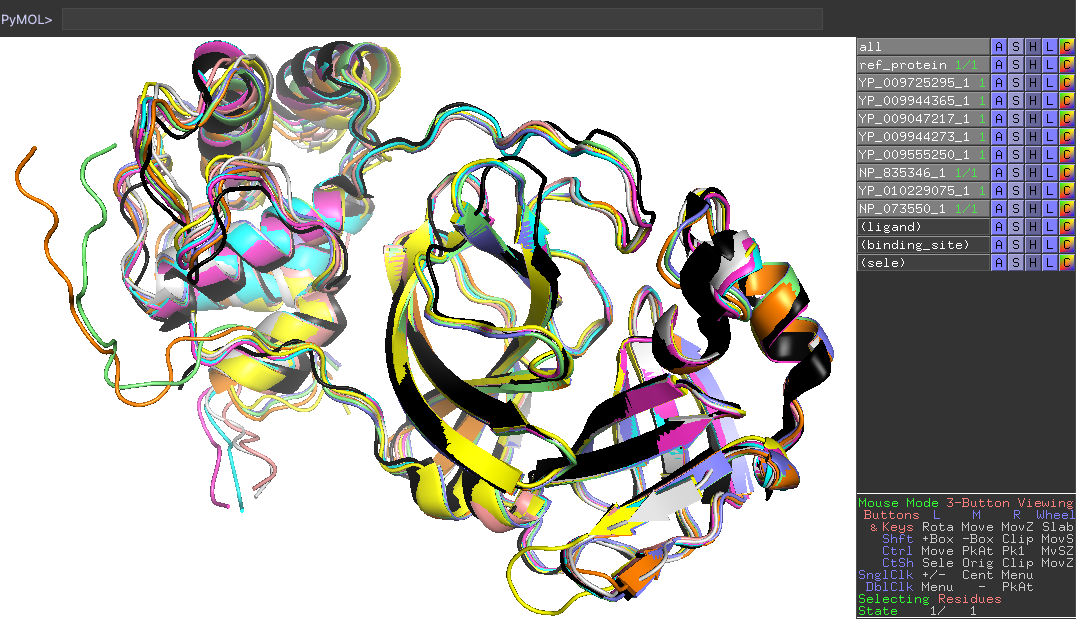

We can clearly see a few differences in the protein structure! For example, **NP_073550_1** and **YP_010229075_1**, Human coronavirus 229E and NL63, repectively, have a longer aminoacid sequence, as we saw in the sequence alignment step. However, most of the structure is still conserved, with the "excess" aminoacids folded at the end of the chain (green an orange, in the PyMOL view above).

## How to run the sequence/structure alignment in the command-line

The sequence and structure alignment pipelines we went through in the previous steps can also be run from the command line. The `asap-genetics` CLI includes both pipelines: `seq-alignment` and `struct-alignment`, respectively. We will go through the usage and a few examples for each option, using the test case adopted in the tutorial above (SARS-CoV-2 Mpro Chain A).

### Sequence alignment usage

Starting from an input protein seqence file, _e.g._, `.fasta`, `.pdb` or pre-computed `.xml` file, the `seq-alignment` command will generate all of the alignment files for the target protein and related protein sequences. 

The `asap-genetics seq-alignment` CLI takes as input the sequence file and the path to the folder where results will be stored, along with a series of options to control the BLAST search and alignment outputs. Below is a list of these options, which can also be accessed via the `asap-genetics seq-alignment --help` option:

      -f, --seq-file FILE           File containing reference sequences
      -t, --seq_type [fasta|pdb|pre-calc]
                                    Type of input from which the sequence will be read. [default: fasta]
      --output-dir DIRECTORY        The directory to output results to.
      --nalign INTEGER              Number of alignments that BLAST search will output.
      --e-thr FLOAT                 Threshold to select BLAST results.
      --save-blast TEXT             Optional file name for saving result of BLAST search
      --sel-key TEXT                Selection key to filter BLAST output.
                                    Provide either a keyword, or 'host: <species>'
      --plot-width INTEGER          Width for the multi-alignment plot.
      --blast-json FILE             Path to a json file containing parameters for the blast search.
      --email TEXT                  Email for Entrez search.
      --multimer                    Store the output sequences for a multimer ColabFold run (from identical chains).
                                    If not set, "--n-chains" will not be used.
      --n-chains INTEGER            Number of repeated chains that will be saved in csv file.
                                    Requires calling the "--multimer" option first.
      --gen-ref-pdb                 Fetch PDB of crystal structure for reference target, from the RCSB database.
      --help                        Show this message and exit.

The following optional arguments control the BLAST search:
- The number of alignments is controled through the `--nalign` option and is set to 1000 by default. Other BLAST API parameters such as the number of hits and the number of descriptions are calculated internally to match the number given for `--nalign`.
- The expect value cutoff is controlled via `--e-thr`, which is 10 by default.
- The blast output is saved to a CSV file, with the path specified via the `--save-blast` option.

The selection string has the same format as the previous tutorial, allowing both keyword and Entrez selections, via the `--sel-key` argument. Make sure to include the email in`--email` when requesting a an Entrez selection. The CLI will throw an error is this is not provided. 

For the test case of a single protein chain of SARS-CoV-2 MPro, which we previously saved as `sars-cov2-mpro.fasta`, we run the following command:

```bash
# Starting from a .fasta file
asap-genetics seq-alignment -f sars-cov2-mpro.fasta -t fasta \
--output-dir tutorial_results \
--sel-key "host: Homo sapiens OR organism: human" \
--email your.email@email.com
```

```bash
# Starting from a .pdb file
asap-genetics seq-alignment -f 8ya5.pdb -t pdb \
--output-dir tutorial_results \
--sel-key "host: Homo sapiens OR organism: human" \
--email your.email@email.com
```

```bash
# Starting from a pre-computed BLAST search (.xml file)
asap-genetics seq-alignment -f results.xml -t pre-calc \
--output-dir tutorial_results \
--sel-key "host: Homo sapiens OR organism: human" \
--email your.email@email.com
```

All of the output files generated are named according to the title of the sequence given in the input fasta file, with an additional prefix that can be added through the `--aln-output` option if desired. The following files are saved in `--results-folder`:
- A CSV file with the results from the BLAST search on the reference sequence (default path is `blast.csv`)
- A `.fasta` file with the ID, description and sequence of the sequences selected via the provided keyword.
- a CSV file with the ID and sequence of the sequences selected via the provided keyword, required for the structure alignment pipeline.
- An `.html` file with a colored representation of the multi-sequence alignment. The width of the plot can be adjusted via `--plot-width`.
- A `.fasta` file with the aligned sequences (with “-” representing gaps inserted)
- If the `--gen-ref-pdb` flag is used, a PDB file corresponding to the crystal structure of the reference sequence. The RCSB entry with the highest resolution is retrieved.

The default setting to generate a ColabFold run CSV input is for monomers, but this can be adjusted for folding multimers. For example, starting from the `fasta` input file:

```bash
# Starting from a .fasta file, generate ColabFold input for a dimer fold
asap-genetics seq-alignment -f sars-cov2-mpro.fasta -t fasta \
--output-dir tutorial_results \
--sel-key "host: Homo sapiens OR organism: human" \
--email your.email@email.com \
--multimer --nchains 2
```
The above will generate the necessary input for folding the related protein sequences as dimers.

Finally, the user can fetch a PDB crystal structures of the reference by optionally providing the flag `--gen-ref-pdb`. Note that this functionality requires previous installation of the ProDy module in the `asapdiscovery` environment. 

### Structure alignment usage

Based on a ColabFold run, as described in the tutorial, the `struct-alignment` command aligns the PDBs of the folded sequences listed in a `.csv` file and generates a PyMOL session for visualization. 

The `asap-genetics struct-alignment` CLI takes as input the csv file, generated from the `seq-alignment` run, the PDB file of the protein that we used as a reference for the two prior steps, the path to the folder where the results from the ColabFold run are stored (the `$out_dir` environment variable assigned to the run on the folding step), and the path to the directory where alignment results will be stored. Below is a list of these options, which can also be accessed via the `asap-genetics struct-alignment --help` option:

      -f, --seq-file FILE        File (csv) containing reference sequences
      --pdb-file FILE            Path to a pdb file containing a structure
      --output-dir DIRECTORY     The directory to output results to.
      --cfold-results DIRECTORY  Path to folder where all ColabFold results are stored.
      --pymol-save TEXT          Path to save pymol session with aligned proteins.
      --cf-format TEXT           Format of pdb file saved by ColabFold, according to the folding model and relaxation used.
      --help                     Show this message and exit.

Optionally, a custom name for the PyMOL session can be provided, with the default being `aligned_proteins.pse`. The format of the PDB file of the folded protein that ColabFold generates can also be controlled by the argument `--cf-format`. The default format is _`"_unrelaxed_rank_001_alphafold2_ptm"`_, which corresponds to a run using the _alphafold2_ptm_ model and no relaxation step. If a multimer model was used for ColabFold, _`"_unrelaxed_rank_001_alphafold2_multimer_v3"`_ would be the correct format, although the string can be verified by looking at the contents of the `--cfold-results` directory. 

The following command will create a PyMOL session based on the ColabFold results stored in the directory `sars_cf_results/`:
```bash
# From the csv file and ColabFold files generated in the previous tutorial steps (monomer run)
asap-genetics struct-alignment -f sars_tutorial_human_host.csv \
--pdb-file 8ya5.pdb \
--output-dir aligned_sars_tutorial \
--cfold-results sars_cf_results
```

```bash
# From the csv file and ColabFold files generated in the previous tutorial steps (dimer run)
asap-genetics struct-alignment -f sars_tutorial_human_host.csv \
--pdb-file dimer.pdb \
--output-dir aligned_sars_tutorial \
--cfold-results sars_cf_results \
--cf-format "_unrelaxed_rank_001_alphafold2_multimer_v3"
```